### Energy Consumption Forecasting with XGBoost

In [121]:
# importing libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import seaborn as sns
from sklearn.metrics import mean_squared_error

import xgboost as xgb

In [122]:
# importing the dataset

df = pd.read_csv('AEP_hourly.csv')
df.head()

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0


In [123]:
df.tail()

,Datetime,AEP_MW
121268,2018-01-01 20:00:00,21089.0
121269,2018-01-01 21:00:00,20999.0
121270,2018-01-01 22:00:00,20820.0
121271,2018-01-01 23:00:00,20415.0
121272,2018-01-02 00:00:00,19993.0


In [124]:
df.shape

(121273, 2)

In [125]:
df.dtypes

Datetime     object
AEP_MW      float64
dtype: object

In [126]:
df.isnull().sum()

Datetime    0
AEP_MW      0
dtype: int64

In [127]:
df['Datetime'] = pd.to_datetime(df['Datetime'])
df = df.set_index('Datetime')
df.head()

,AEP_MW
Datetime,
2004-12-31 01:00:00,13478.0
2004-12-31 02:00:00,12865.0
2004-12-31 03:00:00,12577.0
2004-12-31 04:00:00,12517.0
2004-12-31 05:00:00,12670.0


In [128]:
df.index

DatetimeIndex(['2004-12-31 01:00:00', '2004-12-31 02:00:00',
               '2004-12-31 03:00:00', '2004-12-31 04:00:00',
               '2004-12-31 05:00:00', '2004-12-31 06:00:00',
               '2004-12-31 07:00:00', '2004-12-31 08:00:00',
               '2004-12-31 09:00:00', '2004-12-31 10:00:00',
               ...
               '2018-01-01 15:00:00', '2018-01-01 16:00:00',
               '2018-01-01 17:00:00', '2018-01-01 18:00:00',
               '2018-01-01 19:00:00', '2018-01-01 20:00:00',
               '2018-01-01 21:00:00', '2018-01-01 22:00:00',
               '2018-01-01 23:00:00', '2018-01-02 00:00:00'],
              dtype='datetime64[ns]', name='Datetime', length=121273, freq=None)

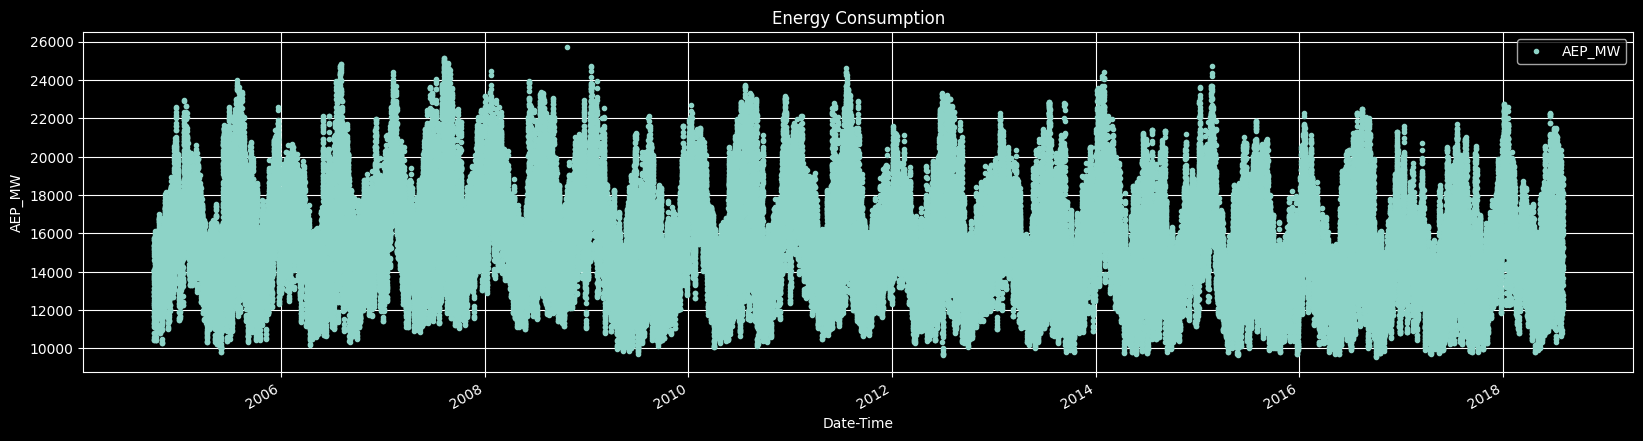

In [129]:
df.plot(style = '.', figsize=(20,5))
plt.xlabel('Date-Time')
plt.ylabel('AEP_MW')
plt.title('Energy Consumption')
plt.grid()
plt.show()

In [130]:
# train test split

train_size = int(len(df)*0.8)
df_train = df.iloc[:train_size]
df_test = df.iloc[train_size:]

print(f'df_train shape: ', df_train.shape)
print(f'df_test shape: ', df_test.shape)

df_train shape:  (97018, 1)
df_test shape:  (24255, 1)


In [131]:
df_train.tail()

,AEP_MW
Datetime,
2015-03-07 04:00:00,17331.0
2015-03-07 05:00:00,17484.0
2015-03-07 06:00:00,17855.0
2015-03-07 07:00:00,18292.0
2015-03-07 08:00:00,18497.0


In [132]:
df_test.head()

,AEP_MW
Datetime,
2015-03-07 09:00:00,18343.0
2015-03-07 10:00:00,17768.0
2015-03-07 11:00:00,17163.0
2015-03-07 12:00:00,16433.0
2015-03-07 13:00:00,15798.0


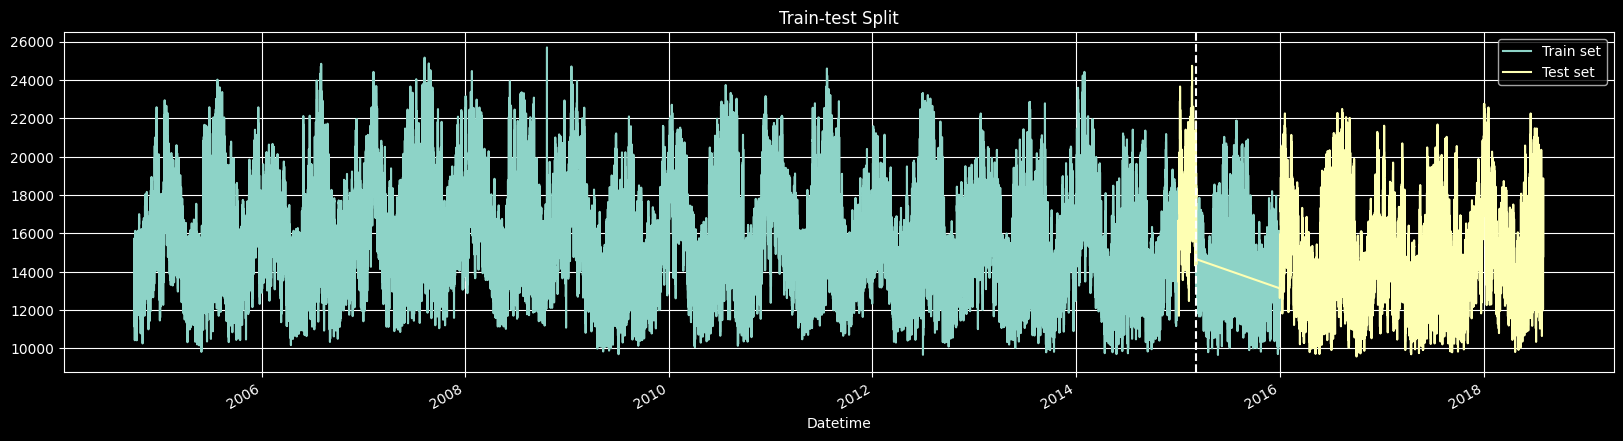

In [133]:
fig,ax = plt.subplots(figsize = (20,5))
df_train.plot(ax=ax, label = 'Train')
df_test.plot(ax=ax,label='Test')
ax.axvline('2015-03-07 09:00:00',color='white',ls = '--')
plt.title('Train-test Split')
ax.legend(['Train set','Test set'])
plt.grid()
plt.show()

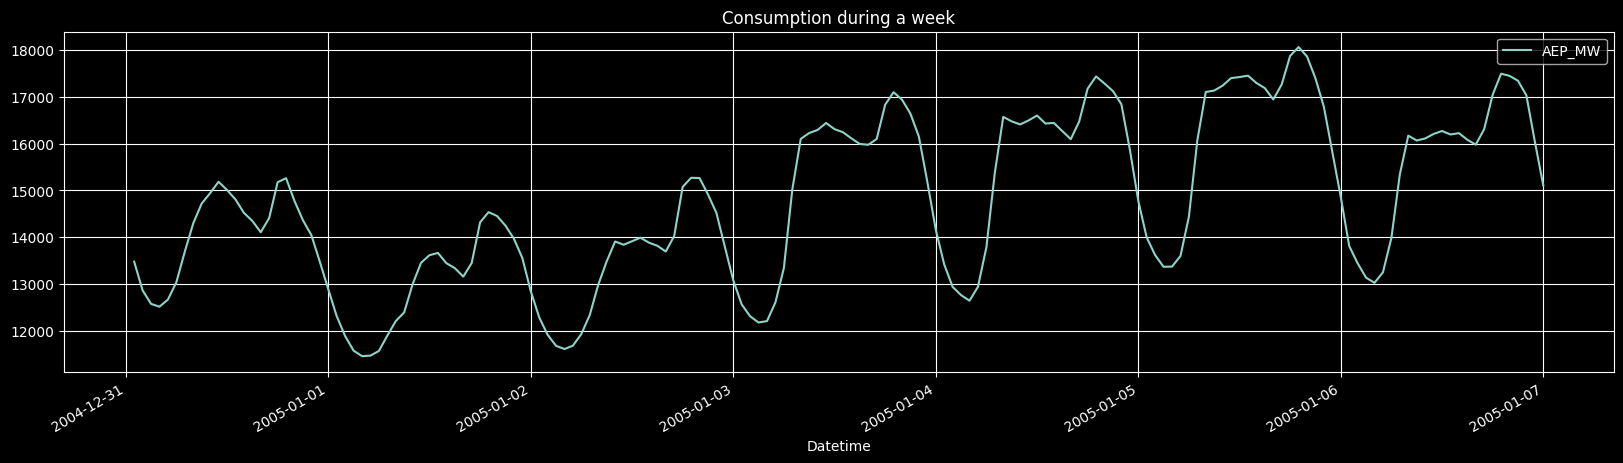

In [134]:
# plotting data of a week

df.iloc[(df.index > '2004-12-31') & (df.index <= '2005-01-07')].plot(figsize=(20,5), title = 'Consumption during a week')
plt.grid()
plt.show()

In [135]:
# Feature Engineering

def create_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear

    return df


In [136]:
df = create_features(df)
df.head()

,AEP_MW,hour,dayofweek,quarter,month,year,dayofyear
Datetime,,,,,,,
2004-12-31 01:00:00,13478.0,1,4,4,12,2004,366
2004-12-31 02:00:00,12865.0,2,4,4,12,2004,366
2004-12-31 03:00:00,12577.0,3,4,4,12,2004,366
2004-12-31 04:00:00,12517.0,4,4,4,12,2004,366
2004-12-31 05:00:00,12670.0,5,4,4,12,2004,366


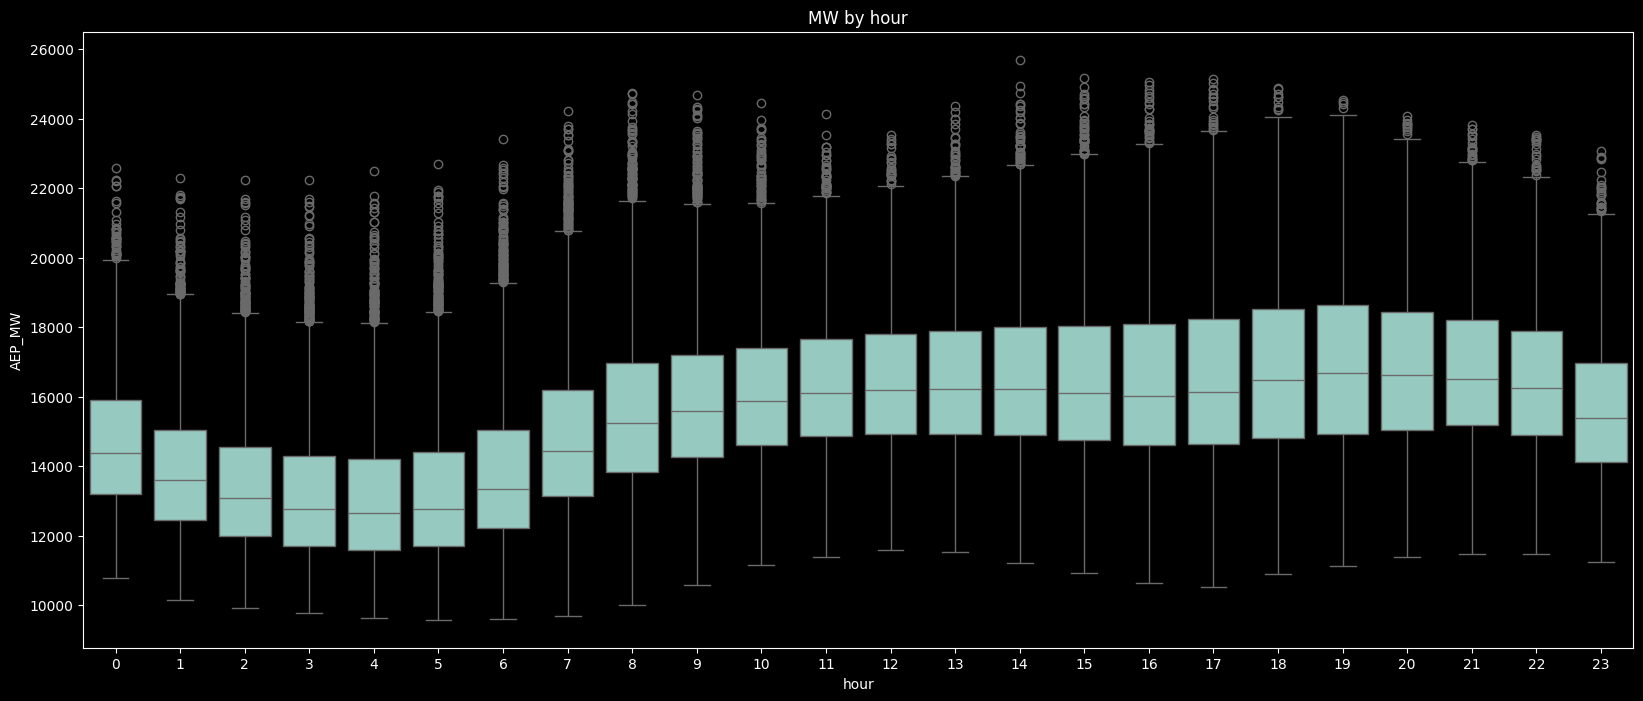

In [137]:
# Visualize Feature/Target relationship

fig,ax = plt.subplots(figsize = (20,8))
sns.boxplot(data = df , x = 'hour', y = 'AEP_MW')
ax.set_title('MW by hour')
plt.show()

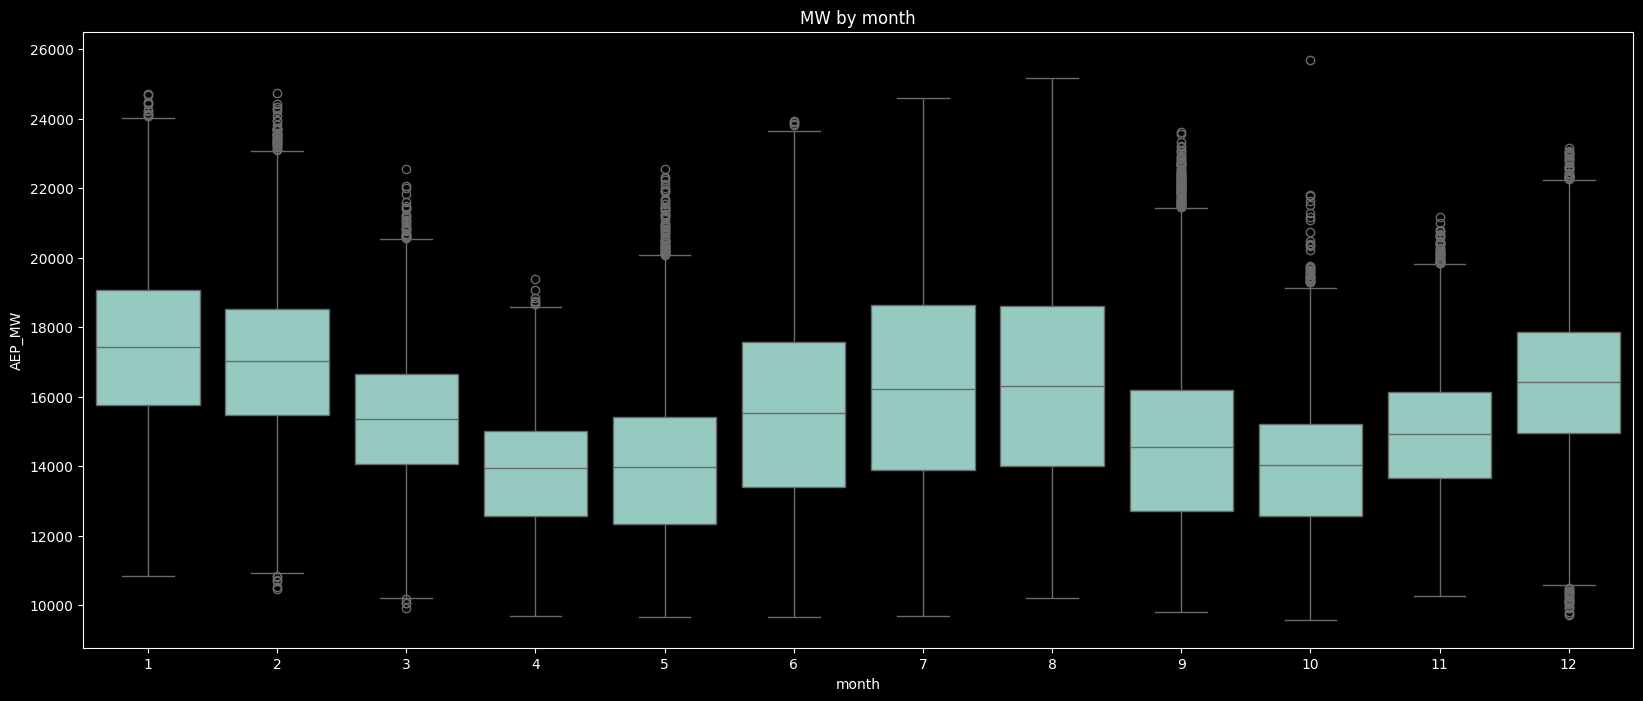

In [138]:
fig,ax = plt.subplots(figsize = (20,8))
sns.boxplot(data = df , x = 'month', y = 'AEP_MW')
ax.set_title('MW by month')
plt.show()

In [139]:
df_train = create_features(df_train)
df_test = create_features(df_test)

In [140]:
df.columns

Index(['AEP_MW', 'hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear'], dtype='object')

In [141]:
FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear']
TARGET = ['AEP_MW']

In [142]:
x_train = df_train[FEATURES]
y_train = df_train[TARGET]

x_test = df_test[FEATURES]
y_test = df_test[TARGET]

In [143]:
# model building

reg = xgb.XGBRegressor(n_estimators =1000, early_stopping_rounds = 50,learning_rate = 0.01)
reg.fit(x_train,y_train,
        eval_set = [(x_train,y_train),(x_test,y_test)],
        verbose = 100)

[0]	validation_0-rmse:2564.68355	validation_1-rmse:2633.55686
[100]	validation_0-rmse:1673.10972	validation_1-rmse:1884.45877
[200]	validation_0-rmse:1384.84962	validation_1-rmse:1735.98356
[300]	validation_0-rmse:1260.75276	validation_1-rmse:1692.49208
[400]	validation_0-rmse:1169.73104	validation_1-rmse:1670.25887
[500]	validation_0-rmse:1112.13566	validation_1-rmse:1662.92151
[573]	validation_0-rmse:1080.95354	validation_1-rmse:1670.24818


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

In [144]:
# feature importance

fi = pd.DataFrame(data = reg.feature_importances_,
             index = reg.feature_names_in_,
             columns = ['feature_importance']).sort_values('feature_importance')

fi

,feature_importance
year,0.062193
dayofyear,0.124090
quarter,0.134423
month,0.138912
dayofweek,0.156722
hour,0.383661


<Axes: title={'center': 'Feature Importance'}>

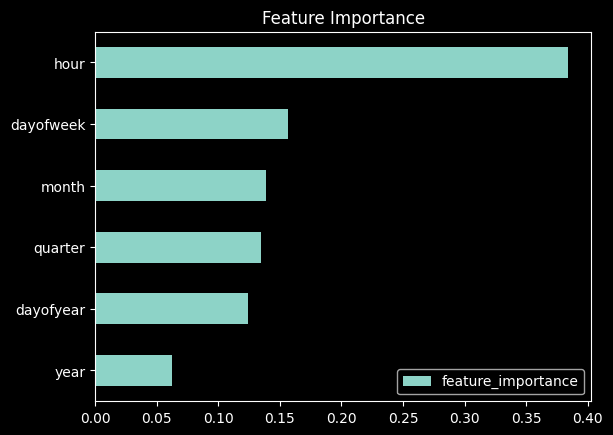

In [145]:
fi.plot(kind='barh',title = 'Feature Importance')

In [146]:
# forecast for test data

df_test['predictions'] = reg.predict(x_test)

In [147]:
df = df.merge(df_test[['predictions']], how = 'left', left_index= True, right_index= True)
df

,AEP_MW,hour,dayofweek,quarter,month,year,dayofyear,predictions
Datetime,,,,,,,,
2004-10-01 01:00:00,12379.0,1,4,4,10,2004,275,NaN
2004-10-01 02:00:00,11935.0,2,4,4,10,2004,275,NaN
2004-10-01 03:00:00,11692.0,3,4,4,10,2004,275,NaN
2004-10-01 04:00:00,11597.0,4,4,4,10,2004,275,NaN
2004-10-01 05:00:00,11681.0,5,4,4,10,2004,275,NaN
...,...,...,...,...,...,...,...,...
2018-08-02 20:00:00,17673.0,20,3,3,8,2018,214,18166.460938
2018-08-02 21:00:00,17303.0,21,3,3,8,2018,214,18010.281250
2018-08-02 22:00:00,17001.0,22,3,3,8,2018,214,17721.984375


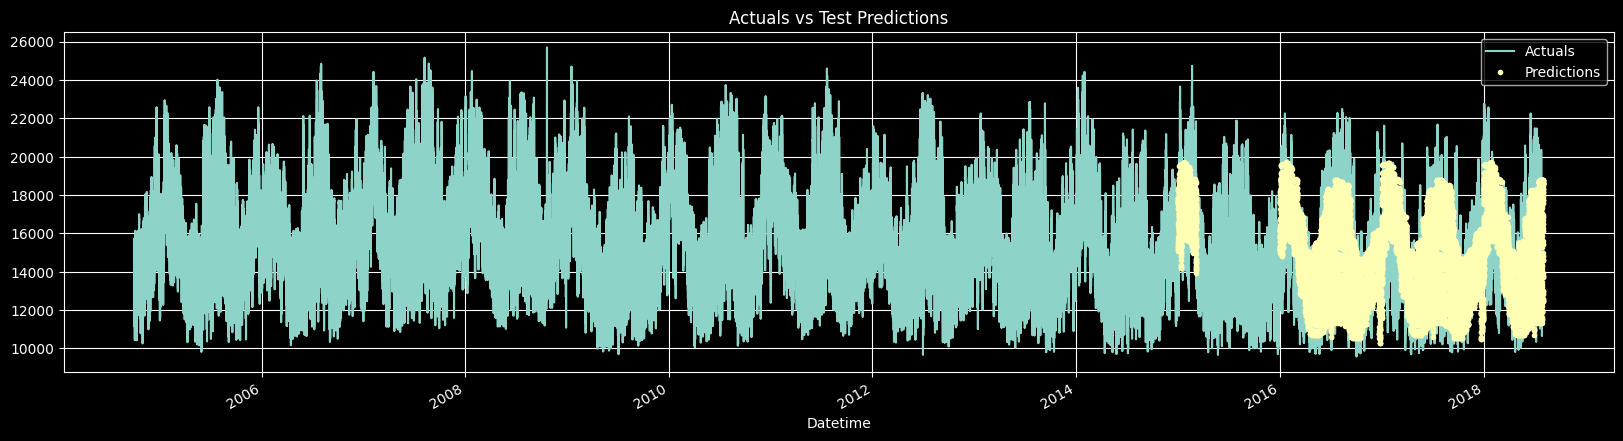

In [148]:
ax = df['AEP_MW'].plot(figsize=(20,5))
df['predictions'].plot(ax=ax,style='.')
plt.legend(['Actuals','Predictions'])
ax.set_title('Actuals vs Test Predictions')
plt.grid()
plt.show()

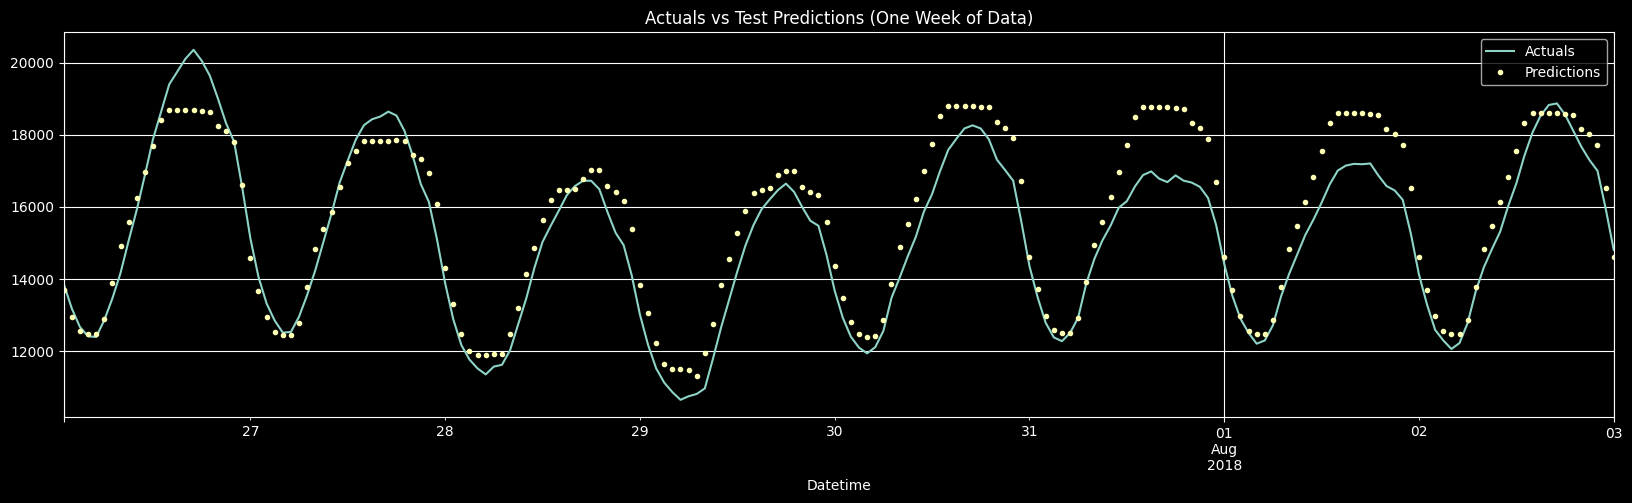

In [149]:
ax = df.iloc[(df.index > '2018-07-26') & (df.index <= '2018-08-03')]['AEP_MW'].plot(figsize=(20,5))
df.iloc[(df.index > '2018-07-26') & (df.index <= '2018-08-03')]['predictions'].plot(ax=ax,style='.')
plt.legend(['Actuals','Predictions'])
ax.set_title('Actuals vs Test Predictions (One Week of Data)')
plt.grid()
plt.show()

In [150]:
# evaluation

score = np.sqrt(mean_squared_error(df_test['AEP_MW'],df_test['predictions']))
print(f'RMSE: {score:0.2f}')

RMSE: 1662.32


In [152]:
df_test

,AEP_MW,hour,dayofweek,quarter,month,year,dayofyear,predictions
Datetime,,,,,,,,
2015-03-07 09:00:00,18343.0,9,5,1,3,2015,66,14919.069336
2015-03-07 10:00:00,17768.0,10,5,1,3,2015,66,14558.281250
2015-03-07 11:00:00,17163.0,11,5,1,3,2015,66,14460.414062
2015-03-07 12:00:00,16433.0,12,5,1,3,2015,66,14446.441406
2015-03-07 13:00:00,15798.0,13,5,1,3,2015,66,14325.508789
...,...,...,...,...,...,...,...,...
2018-01-01 20:00:00,21089.0,20,0,1,1,2018,1,18337.818359
2018-01-01 21:00:00,20999.0,21,0,1,1,2018,1,18428.738281
2018-01-01 22:00:00,20820.0,22,0,1,1,2018,1,18347.421875


In [153]:
# worst and best predicted days

df_test['error'] = np.abs(df_test['AEP_MW']-df_test['predictions'])
df_test['Date'] = df_test.index.date
df_test.groupby('Date')['error'].mean().sort_values(ascending=False).head(5)

Date
2017-12-28    5791.619832
2015-02-19    5262.445801
2015-02-20    5211.130127
2017-12-31    5177.245239
2017-12-27    4923.973958
Name: error, dtype: float64

In [154]:
df_test.groupby('Date')['error'].mean().sort_values(ascending=True).head(5)

Date
2017-11-02    148.633057
2016-01-23    157.644124
2017-10-12    164.932739
2018-08-03    206.885742
2017-03-19    222.632446
Name: error, dtype: float64